In [15]:
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd
import pydotplus
import seaborn as sns
from IPython.display import Image
from graphviz import Source
from sklearn import metrics as met
from sklearn.externals.six import StringIO
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

In [16]:
def create_dict_table_from_json(conn, filepath, table_name):
    df = pd.read_json(filepath, precise_float=True)
    df.columns = map(str.upper, df.columns)
    df.to_sql(table_name, conn, if_exists='replace', index=False)
    conn.commit()


def create_table_from_csv(conn, filepath, table_name):
    df = pd.read_csv(filepath)
    df.columns = map(str.upper, df.columns)
    df.to_sql(table_name, conn, if_exists='replace', index=False)
    conn.commit()

In [17]:
conn = sqlite3.connect("project.db")
create_table_from_csv(conn, "fma-rock-vs-hiphop.csv", "TRACKS")
create_dict_table_from_json(conn, "echonest-metrics.json", "METRICS")

# Read in track metadata with genre labels
conn = sqlite3.connect("project.db")

In [18]:
def get_data(conn):
    sql = " Select Metrics.TRACK_ID,Metrics.ACOUSTICNESS,Metrics.DANCEABILITY,Metrics.ENERGY," \
          "Metrics.INSTRUMENTALNESS,Metrics.LIVENESS," \
          "Metrics.SPEECHINESS,Metrics.TEMPO,Metrics.VALENCE,Tracks.GENRE_TOP " \
          "from Metrics " \
          "join TRACKS " \
          "on Metrics.TRACK_ID=Tracks.TRACK_ID ORDER BY RANDOM();"
    return pd.read_sql(sql, conn)

In [19]:
# split the data into 70:30 ratio for train:test
data = get_data(conn)
data.info()
train_data, test_data = train_test_split(data, test_size=0.3)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TRACK_ID          4802 non-null   int64  
 1   ACOUSTICNESS      4802 non-null   float64
 2   DANCEABILITY      4802 non-null   float64
 3   ENERGY            4802 non-null   float64
 4   INSTRUMENTALNESS  4802 non-null   float64
 5   LIVENESS          4802 non-null   float64
 6   SPEECHINESS       4802 non-null   float64
 7   TEMPO             4802 non-null   float64
 8   VALENCE           4802 non-null   float64
 9   GENRE_TOP         4802 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 375.3+ KB


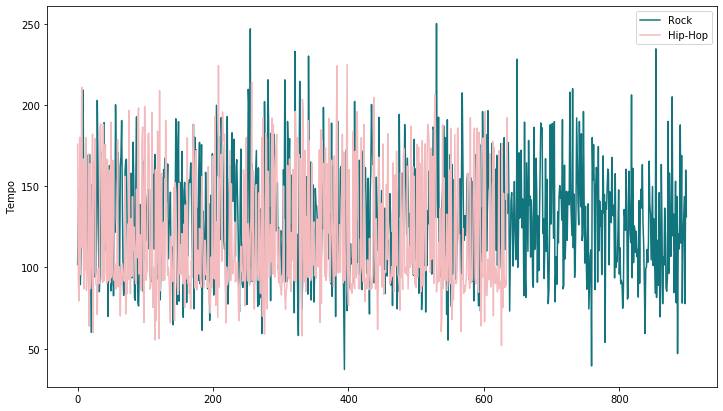

In [20]:
plt.rcParams['figure.figsize'] = [12, 7]
rock = list(train_data.loc[train_data['GENRE_TOP'] == "Rock", 'TEMPO'])[0:900]
hip_hop = list(train_data.loc[train_data['GENRE_TOP'] == "Hip-Hop", 'TEMPO'])[0:900]
plt.plot(rock, label="Rock", color="#12757d")
plt.plot(hip_hop, label="Hip-Hop", color="#f4bbbf")
plt.ylabel("Tempo")
plt.legend()

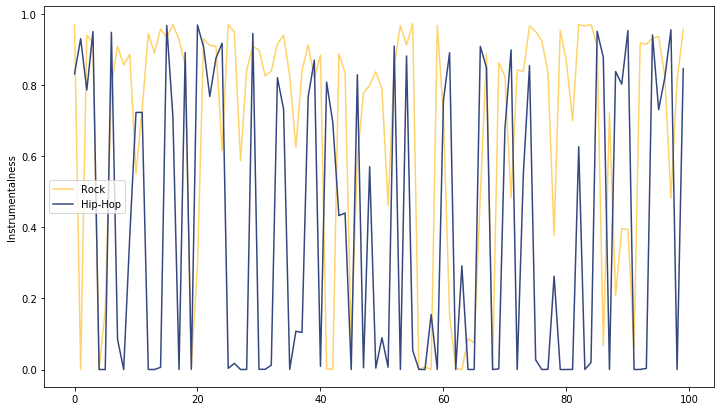

In [21]:
rock = list(train_data.loc[train_data['GENRE_TOP'] == "Rock", 'INSTRUMENTALNESS'])[0:100]
hip_hop = list(train_data.loc[train_data['GENRE_TOP'] == "Hip-Hop", 'INSTRUMENTALNESS'])[0:100]
plt.plot(rock, label="Rock", color="#ffd369")
plt.plot(hip_hop, label="Hip-Hop", color="#35477d")
plt.ylabel("Instrumentalness")
plt.legend()

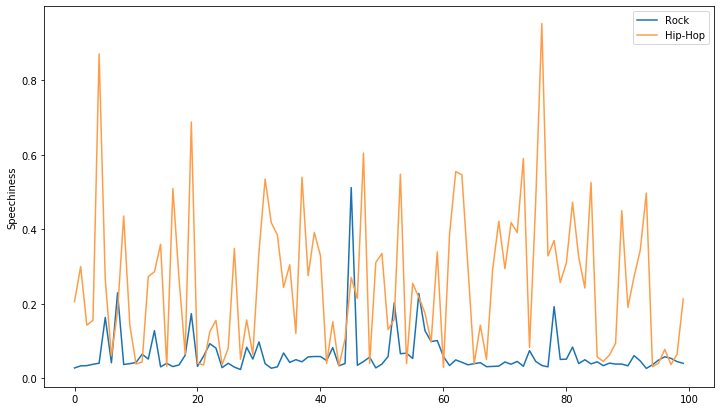

In [22]:
rock = list(train_data.loc[train_data['GENRE_TOP'] == "Rock", 'SPEECHINESS'])[0:100]
hip_hop = list(train_data.loc[train_data['GENRE_TOP'] == "Hip-Hop", 'SPEECHINESS'])[0:100]
plt.plot(rock, label="Rock", color="#1973b2")
plt.plot(hip_hop, label="Hip-Hop", color="#ff9d47")
plt.ylabel("Speechiness")
plt.legend()


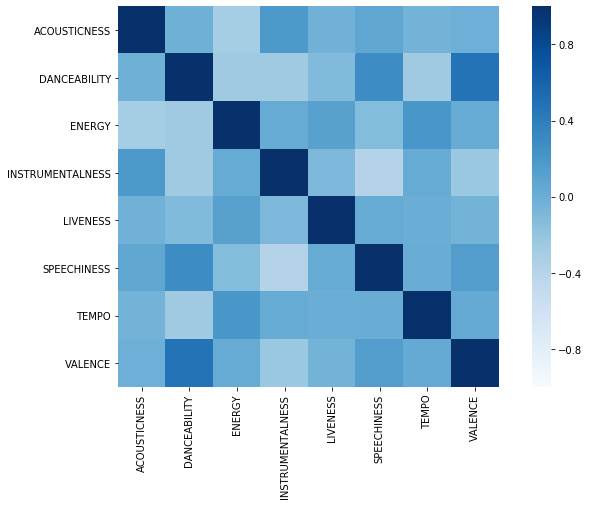

In [23]:
corr = train_data.iloc[:, 1:10].corr()
corr_metrics = train_data.corr()
corr_metrics.style.background_gradient()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap="Blues",
    square=True
)

In [24]:
features = data.drop(["GENRE_TOP", "TRACK_ID"], axis=1)
labels = data["GENRE_TOP"]
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=10)

# Train decision tree on unbalanced data
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features, train_labels)

pred_labels_tree = tree.predict(test_features)
print("Accuracy on unbalanced data: ", met.accuracy_score(test_labels, pred_labels_tree))


Accuracy on unbalanced data:  0.8726061615320566


In [25]:
logreg = LogisticRegression(random_state=10)
logreg.fit(train_features, train_labels)
pred_logistic = logreg.predict(test_features)

tree_report = classification_report(test_labels, pred_labels_tree)
logistic_report = classification_report(test_labels, pred_logistic)

print("Decision Tree: \n", tree_report)
print("Logistic Regression: \n", logistic_report)

hip_hop_only = train_data.loc[train_data["GENRE_TOP"] == "Hip-Hop"]

rock_only = train_data.loc[train_data["GENRE_TOP"] == "Rock"].sample(len(hip_hop_only), random_state=10)

rock_hop_bal = pd.concat([rock_only, hip_hop_only])

features = rock_hop_bal.drop(['GENRE_TOP', 'TRACK_ID'], axis=1)
labels = rock_hop_bal['GENRE_TOP']

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.70      0.67      0.68       248
        Rock       0.91      0.93      0.92       953

    accuracy                           0.87      1201
   macro avg       0.81      0.80      0.80      1201
weighted avg       0.87      0.87      0.87      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.83      0.52      0.64       248
        Rock       0.89      0.97      0.93       953

    accuracy                           0.88      1201
   macro avg       0.86      0.74      0.78      1201
weighted avg       0.87      0.88      0.87      1201



C:\Users\Madhur\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy on balanced data:  0.8726061615320566


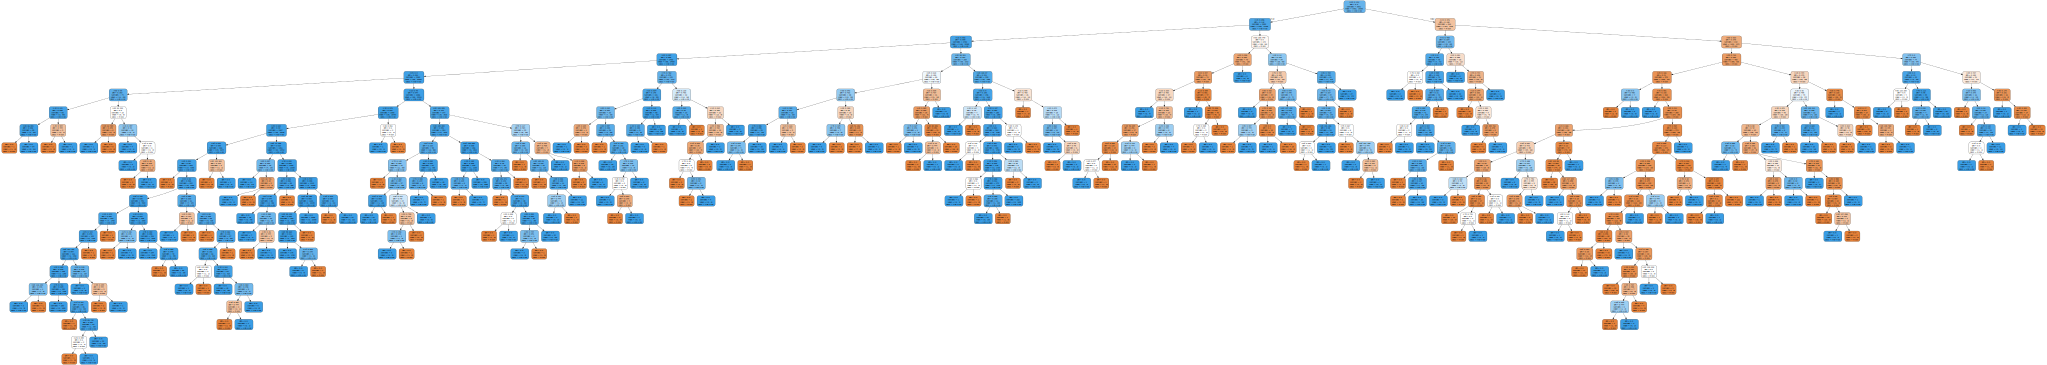

InvocationException: GraphViz's executables not found

In [26]:
# Train our decision tree on the balanced data
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features, train_labels)
pred_labels_tree = tree.predict(test_features)
print("Accuracy on balanced data: ", met.accuracy_score(test_labels, pred_labels_tree))
export_graphviz(tree, out_file='tree.dot')
dot_data = StringIO()
export_graphviz(tree, out_file=dot_data, filled=True, rounded=True, special_characters=True,
                class_names=['Rock', 'Hip-Hop'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph_image = Source(graph.to_string())
graph_image
from IPython.display import display
display(graph_image)
graph.write_pdf("tree_balanced.pdf")
Image(graph.create_png())


Accuracy on pruned data:  0.88759367194005


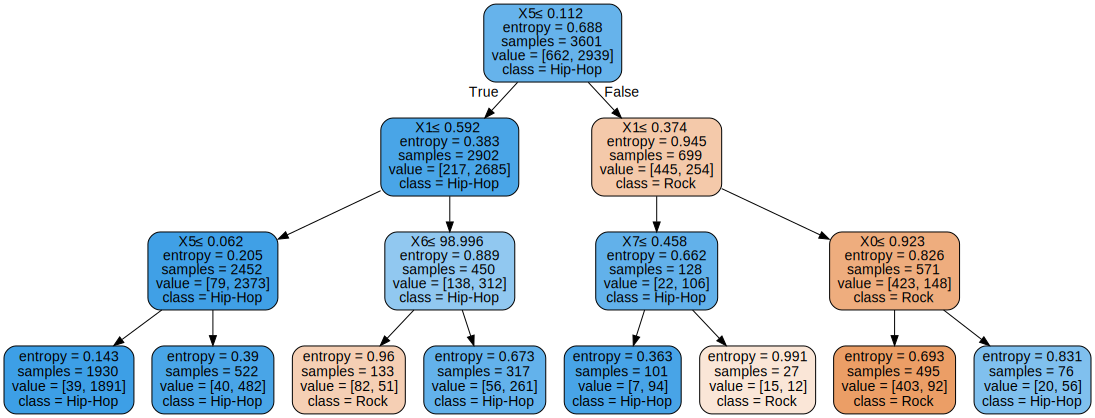

InvocationException: GraphViz's executables not found

In [27]:
tree = DecisionTreeClassifier(criterion="entropy", max_depth=3)
tree.fit(train_features, train_labels)
pred_labels_tree = tree.predict(test_features)
print("Accuracy on pruned data: ", met.accuracy_score(test_labels, pred_labels_tree))
export_graphviz(tree, out_file='tree.dot')
dot_data = StringIO()
export_graphviz(tree, out_file=dot_data, filled=True, rounded=True, special_characters=True,
                class_names=['Rock', 'Hip-Hop'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph_image = Source(graph.to_string())
graph_image
from IPython.display import display
display(graph_image)
graph.write_pdf("tree_pruned.pdf")

In [28]:
# Train our logistic regression on the balanced data
logreg = LogisticRegression(random_state=10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

# Compare the models
print("Decision Tree: \n", classification_report(test_labels, pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels, pred_labels_logit))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.74      0.71      0.72       248
        Rock       0.92      0.93      0.93       953

    accuracy                           0.89      1201
   macro avg       0.83      0.82      0.83      1201
weighted avg       0.89      0.89      0.89      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.83      0.52      0.64       248
        Rock       0.89      0.97      0.93       953

    accuracy                           0.88      1201
   macro avg       0.86      0.74      0.78      1201
weighted avg       0.87      0.88      0.87      1201



C:\Users\Madhur\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
